# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import viewdat_cno_lib as vdl

# Read Files

In [26]:
df_ref = vdl.read_df('240725/outputs/BX_all_0')
df_ref = df_ref.head(500)

df_dut = vdl.read_df('240725/outputs/EB79_all_0')
df_dut = df_dut.head(500)

# Dictionaries

In [35]:
# SV Signal (Track) (see: http://wiki.eng.trimble.com/index.php/SV_Signal):
D_TRACK_TYPE = {
    0: 'CA',               # 0: C/A - (GPS/GLONASS/SBAS) / BOC(1,1) - Galileo
    1: 'P',                # 1: P
    2: 'E',                # 2: Enhanced Cross Correlation
    3: 'CM',               # 3: L2C (CM)
    4: 'CL',               # 4: L2C (CL)
    5: 'CM+CL',            # 5: L2C (CM+CL)
    6: 'I',                # 6: L5 (I)
    7: 'Q',                # 7: L5 (Q)
    8: 'I+Q',              # 8: L5 (I+Q)
    9: 'Y',                # 9: Y
    10: 'M',               # 10: M
    11: 'BPSK(10)-PD',     # 11: BPSK(10)-PD (Galileo E5A or E5B - Pilot & Data) # noqa: E501
    12: 'BPSK(10)-P',      # 12: BPSK(10)-P (Galileo E5A or E5B - Pilot only)
    13: 'BPSK(10)-D',      # 13: BPSK(10)-D (Galileo E5A or E5B - Data only, Beidou-2/Compass B2 & B3?) # noqa: E501
    14: 'AltBOC-Comp-PD',  # 14: AltBOC-Comp-PD (Galileo Component Mode AltBOC - Pilot & Data) # noqa: E501
    15: 'AltBOC-Comp-P',   # 15: AltBOC-Comp-P (Galileo Component Mode AltBOC - Pilot only) # noqa: E501
    16: 'AltBOC-Comp-D',   # 16: AltBOC-Comp-D (Galileo Component Mode AltBOC - Data only) # noqa: E501
    17: 'AltBOC-PD',       # 17: AltBOC-PD (Galileo Non-Component Mode AltBOC - Pilot & Data) # noqa: E501
    18: 'L2-ECC',          # 18: L2 Enhanced Cross Correlation (L1 estimate derived from P1 estimate (type 19)) # noqa: E501
    19: 'L1-ECC',          # 19: L1 Enhanced Cross Correlation (W-code tracking) # noqa: E501
    20: 'BOC-PD',          # 20: BOC(1,1) Pilot & Data - Galileo E1/GPS L1C
    21: 'BOC-P',           # 21: BOC(1,1) Pilot Only - Galileo E1/GPS L1C
    22: 'BOC-D',           # 22: BOC(1,1) Data Only - Galileo E1/GPS L1C
    23: 'MBOC-PD',         # 23: MBOC[1](1,1) Pilot & Data - Galileo E1/GPS L1C
    24: 'MBOC-P',          # 24: MBOC[1](1,1) Pilot Only - Galileo E1/GPS L1C
    25: 'MBOC-D',          # 25: MBOC[1](1,1) Data Only - Galileo E1/GPS L1C
    26: 'BPSK(2)-B1',      # 26: BPSK(2) (Beidou-2/Compass B1)
    27: 'BPSK(2)-B1-2',    # 27: BPSK(2) (Beidou-2/Compass B1-2)
    28: 'BPSK(2)-B2',      # 28: BPSK(2) (Beidou-2/Compass B2)
    29: 'BPSK(10)-B3',     # 29: BPSK(10) (Beidou-2/Compass B3)
    30: 'SLAS',            # 30: QZSS L1 C/A SBAS like signal (SAIF/SLAS)
    31: 'LEX',             # 31: QZSS LEX signal (pilot component only)
    32: 'PD',              # 32: G3-PD (Glonass G3 CDMA BPSK(10) - Pilot & Data) # noqa: E501
    33: 'P',               # 33: G3-P (Glonass G3 CDMA BPSK(10) - Pilot)
    34: 'D',               # 34: G3-D (Glonass G3 CDMA BPSK(10) - Data)
    35: 'XPS code',        # 35: Terralite XPS code
    36: 'BPSK(5)-PD',      # 36: E6-PD (Galileo E6 BPSK(5) - Pilot & Data)
    37: 'BPSK(5)-P',       # 37: E6-P (Galileo E6 BPSK(5) - Pilot)
    38: 'BPSK(5)-D',       # 38: E6-D (Galileo E6 BPSK(5) - Data)
    #                      # 39: L5S-PD (QZSS L5S BPSK(10) - Pilot & Data)
    #                      # 40: L5S-P (QZSS L5S BPSK(10) - Pilot)
    #                      # 41: L5S-D (QZSS L5S BPSK(10) - Data)
}

# Note: Casting SVType, Freq as int16 doesn't really save on space, or
# processing time, because they get converted to strings, with the lookup
# tables above.
REC35_DTYPE_DICT = {
    'Week': 'int16',
    'SV': 'int16',
    'FDMA': 'int16',
    'SVChan': 'int16',
    'SV_FLAGS': 'int16',
    'RAIM': 'int16',
    'Antenna': 'int16',
    'CSTATE': 'int16',
    'SCINT_FLAGS': 'int16',
    'Track': 'int16',
    'MEAS': 'int16',
    'Count': 'int16',
    'PHASE': 'float32',
    'El': 'int16',
    'Track': 'int16',
}


# Functions

In [10]:
def obs_query_unique(dfa, dfb, query_col, val, unique_col):
    '''
    For two DataFrames, use only the rows where val is in query_col, and return
    a list of unique values in unique_col.

    Example:
        freqs = obs_query_unique(df_ref, df_dut, 'SVType', 'GPS', 'Freq')
    This returns a list of unique values in the 'Freq' column that exists in
    either dfa or dfb, where the SVType=='GPS'.
    '''
    # Using list(set(dfa) & set(dfb)) is probably faster, but using pd.concat()
    # preserves the order.
    unique_list = pd.concat([dfa[unique_col], dfb[unique_col]]).unique()
    return unique_list

In [29]:
def obs_calc_phase_deltas(df_ref, df_dut):
    '''
    On a per timestamp, SVType, SV, and Freq basis, calculate C/No deltas.

    Calculated as df_ref - df_dut

    Note: negative numbers mean the df_dut has better C/No.
          positive numbers mean the df_ref has better C/No.

    df_ref, df_dut are pandas.DataFrame structures, in the format output
    by obs_read(). But really, all that matters are the Week, Time, SV, SVType,
    Freq, and CNo columns.
    '''
    sv_types = pd.concat([df_ref.SVType, df_dut.SVType]).unique()

    f_err = ['Time', 'SVType', 'Freq', 'SV', 'SVChan', 'Antenna',
             'Track', 'FDMA', 'MEAS', 'RANGE', 'DOPP']
    df_diff = pd.DataFrame()

    merge_cols = ['Week', 'Time', 'SV', 'SVType', 'Freq',
                  'PHASE_DIFF', 'Track', 'SVChan', 'FDMA', 'Az', 'El', 'adj_time']
    for s in sv_types:
        freqs = obs_query_unique(df_ref, df_dut, 'SVType', s, 'Freq')
        for f in freqs:
            q = "SVType=='{}' and Freq=='{}'".format(s, f)
            df_ref_sf = df_ref.query(q)
            df_dut_sf = df_dut.query(q)

            tracks = list(set(df_ref_sf.Track) & set(df_ref_sf.Track))
            for tn in tracks:
                qt = "Track=={}".format(tn)
                df_ref_sft = df_ref_sf.query(qt)
                df_dut_sft = df_dut_sf.query(qt)

                if s == 'GLONASS':
                    on = ['Week', 'Time', 'FDMA']
                else:
                    on = ['Week', 'Time', 'SV']

                # the PRNs common to both DataFrames
                prns = list(set(df_ref_sf.SV) & set(df_ref_sf.SV))
                for p in prns:
                    qsv = "SV=={}".format(p)
                    df_ref_sfp = df_ref_sft.query(qsv)
                    df_dut_sfp = df_dut_sft.query(qsv)

                    # Note: in the resulting merged DataFrame, the '*_y'
                    # columns are from the Reference DF, while the '*_x'
                    # columns are from the DUT DF.
                    df_merged = df_ref_sfp.merge(
                            df_dut_sfp, how='inner', on=on)
                    diff = df_merged.CNo_y - df_merged.CNo_x
                    df_merged.insert(3, "PHASE_DIFF", diff, True)
                    df_merged.rename(columns={"SV_x": "SV",
                                              "SVType_x": "SVType",
                                              "Freq_x": "Freq",
                                              "SVChan_x": "SVChan",
                                              "FDMA_x": "FDMA",
                                              "Track_x": "Track",
                                              "Antenna_x": "Antenna",
                                              "Offset_x": "Offset",
                                              "RAIM_x": "RAIM",
                                              "Az_x": "Az",
                                              "El_x": "El",
                                              "PHASE_x": "PHASE",
                                              #"RANGE_x": "RANGE",
                                              "DOPP_x": "DOPP",
                                              "MEAS_x": "MEAS",
                                              "adj_time_x": "adj_time",
                                              }, inplace=True)
                    # From the GNSS Wiki:
                    # SV CHANNEL is the FDMA channel (Appropriate only for
                    # GLONASS SVs). In pre-3.50 firmware for GPS/SBAS this
                    # field was to zero. This byte should now be considered a
                    # reserved byte for non-GLONASS applications. Currently in
                    # test code we are using this to indicate the physical
                    # hardware channel for Galileo/GPS/SBAS satellites, this
                    # allows us to track the satellite on two channels running
                    # different algorithms for testing and unambiguously
                    # retrieve the data. Unless the satellite is GLONASS all
                    # processing software should consider this a reserved byte
                    # and not use it.
                    #
                    # When saving to an HDF5, it issues a performance warning
                    # when the data types of a column are mix (ie int vs list
                    # of ints). However, profiling of always creating a list vs
                    # only creating a list when they are different, showed that
                    # the 2nd option is slightly faster, both in this loop, and
                    # for storing the resulting DataFrame as an HDF5.
                    #
                    # Note: feather files can't handle a column like:
                    #      [nan, 34, [34, 35], [nan, 35] ..]
                    # Probably the NaNs are the biggest issue. But to force
                    # compatability, we will just always SVChan a list.
                    df_merged.SVChan = df_merged[
                            ['SVChan_y', 'SVChan']].values.tolist()

                    # Note: concatenating DataFrames is potentially quite slow,
                    # but with the way we are doing the difference/merge, we
                    # get many rows in the DataFrame, so it is hard to break
                    # it down into a dictionary per row to enable the faster
                    # df = pd.DataFrame([dict, ..., dict]) concatenation, where
                    # we would do a list.append(dict) in each iteration here.
                    df_diff = pd.concat([df_diff, df_merged[merge_cols]])

                    # Sanity Checks
                    w = f'WARNING: {q} {qsv}'
                    if df_merged.shape[0] > df_ref_sfp.shape[0]:
                        print(w + ' more diff results ({}) than in REF ({})'.
                              format(df_merged.shape[0], df_ref_sfp.shape[0]))
                        df_ref_sfp[f_err].to_csv(
                                'df_ref_sfp.csv', sep='\t', index=False)
                        df_dut_sfp[f_err].to_csv(
                                'df_dut_sfp.csv', sep='\t', index=False)
                        df_merged[f_err].to_csv(
                                'df_merged.csv', sep='\t', index=False)
                        sys.exit()
                    if df_merged.shape[0] > df_dut_sfp.shape[0]:
                        print(w + ' more diff results ({}) than in DUT ({})'.
                              format(df_merged.shape[0], df_dut_sfp.shape[0]))
                        df_ref_sfp[f_err].to_csv(
                                'df_ref_sfp.csv', sep='\t', index=False)
                        df_dut_sfp[f_err].to_csv(
                                'df_dut_sfp.csv', sep='\t', index=False)
                        df_merged[f_err].to_csv(
                                'df_merged.csv', sep='\t', index=False)
                        sys.exit()

    df_diff.sort_values(by=['Time'], inplace=True)
    return df_diff

df_diff = obs_calc_phase_deltas(df_ref, df_dut)
display(df_diff)

Week      Time     SV   SVType   Freq  PHASE_DIFF  Track        SVChan  \
0   2324.0  327600.0   32.0      GPS     L1        -3.5    0.0  [23.0, 28.0]   
0   2324.0  327600.0  135.0     SBAS     L1        -0.2    0.0  [55.0, 55.0]   
0   2324.0  327600.0   23.0      GPS     L1        -0.7    0.0  [18.0, 17.0]   
0   2324.0  327600.0   10.0      GPS     L1        -0.2    0.0  [25.0, 35.0]   
0   2324.0  327600.0   29.0      GPS     L1         0.7    0.0  [14.0, 14.0]   
..     ...       ...    ...      ...    ...         ...    ...           ...   
3   2324.0  327603.0   11.0  Galileo  E5A+B        -0.3   14.0  [38.0, 38.0]   
3   2324.0  327603.0   10.0  Galileo  E5A+B        -0.7   14.0  [43.0, 41.0]   
3   2324.0  327603.0   18.0      GPS     L1        -0.2    0.0  [33.0, 30.0]   
3   2324.0  327603.0   23.0      GPS     L1        -0.9    0.0  [18.0, 17.0]   
3   2324.0  327603.0   32.0      GPS     L1        -3.1    0.0  [23.0, 28.0]   

    FDMA      Az    El  adj_time  
0    0.0  203.75   8.0  327600.0  
0    0.0  209.50  39.0  327600.0  
0    0.0  294.75  66.0  327600.0  
0    0.0  262.50  34.0  327600.0  
0    0.0  168.00  20.0  327600.0  
..   ...     ...   ...       ...  
3    0.0  308.50  33.0  327603.0  
3    0.0  325.00  60.0  327603.0  
3    0.0   68.00  74.0  327603.0  
3    0.0  294.75  66.0  327603.0  
3    0.0  203.75   8.0  327603.0  

[297 rows x 12 columns]

Plotting PHASE_DIFF vs adj_time for GPS, L1


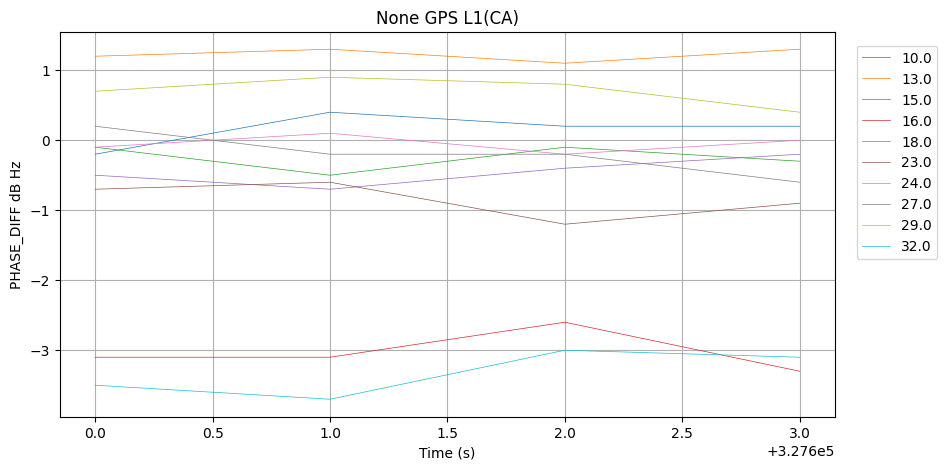

Plotting PHASE_DIFF vs adj_time for GPS, E5A+B
Plotting PHASE_DIFF vs adj_time for GPS, L2


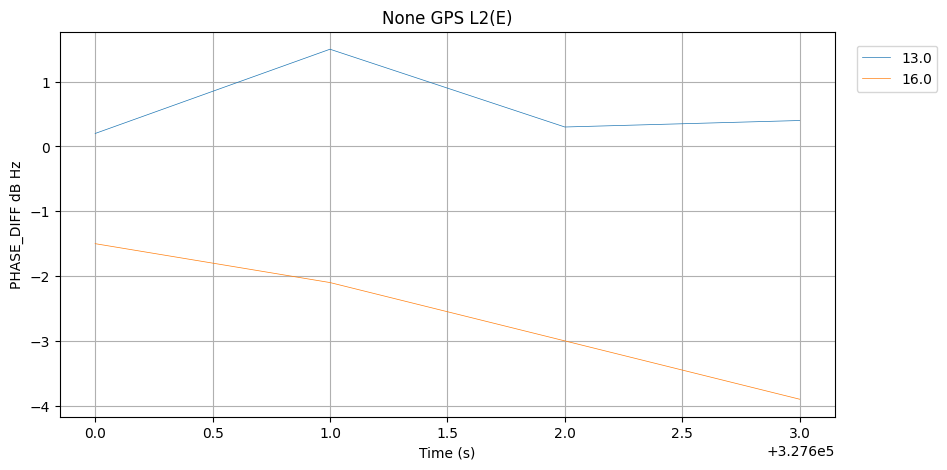

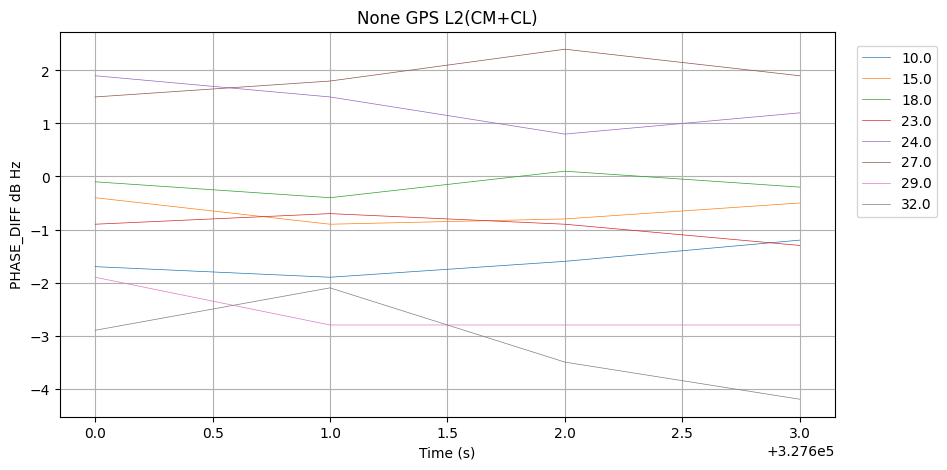

Plotting PHASE_DIFF vs adj_time for GPS, E6
Plotting PHASE_DIFF vs adj_time for GPS, L5/E5A


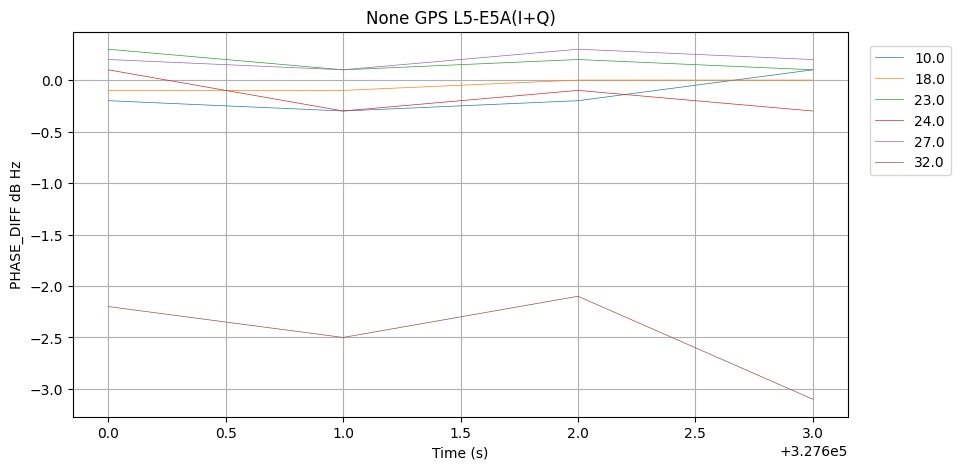

Plotting PHASE_DIFF vs adj_time for GPS, B3
Plotting PHASE_DIFF vs adj_time for GPS, B1
Plotting PHASE_DIFF vs adj_time for GPS, E5B/B2
Plotting PHASE_DIFF vs adj_time for SBAS, L1


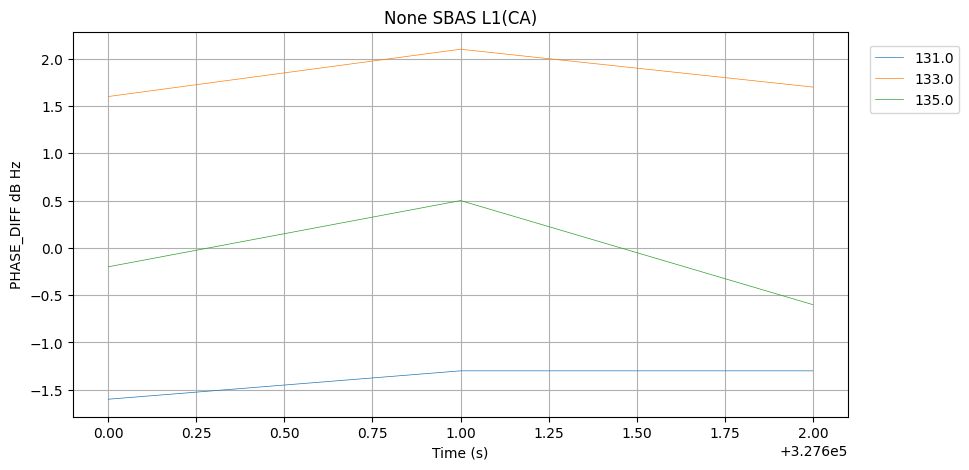

Plotting PHASE_DIFF vs adj_time for SBAS, E5A+B
Plotting PHASE_DIFF vs adj_time for SBAS, L2
Plotting PHASE_DIFF vs adj_time for SBAS, E6
Plotting PHASE_DIFF vs adj_time for SBAS, L5/E5A
Plotting PHASE_DIFF vs adj_time for SBAS, B3
Plotting PHASE_DIFF vs adj_time for SBAS, B1
Plotting PHASE_DIFF vs adj_time for SBAS, E5B/B2
Plotting PHASE_DIFF vs adj_time for Galileo, L1
Plotting PHASE_DIFF vs adj_time for Galileo, E5A+B


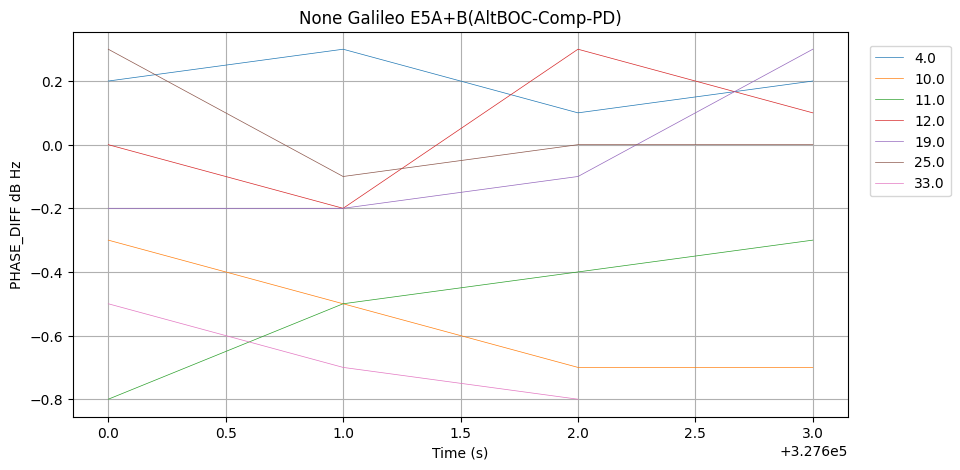

Plotting PHASE_DIFF vs adj_time for Galileo, L2
Plotting PHASE_DIFF vs adj_time for Galileo, E6


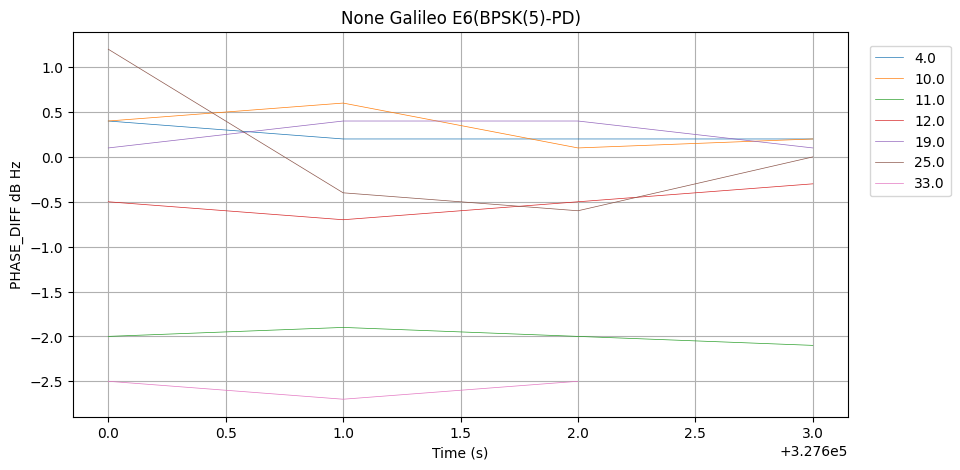

Plotting PHASE_DIFF vs adj_time for Galileo, L5/E5A
Plotting PHASE_DIFF vs adj_time for Galileo, B3
Plotting PHASE_DIFF vs adj_time for Galileo, B1
Plotting PHASE_DIFF vs adj_time for Galileo, E5B/B2
Plotting PHASE_DIFF vs adj_time for BeiDou, L1
Plotting PHASE_DIFF vs adj_time for BeiDou, E5A+B
Plotting PHASE_DIFF vs adj_time for BeiDou, L2
Plotting PHASE_DIFF vs adj_time for BeiDou, E6
Plotting PHASE_DIFF vs adj_time for BeiDou, L5/E5A
Plotting PHASE_DIFF vs adj_time for BeiDou, B3


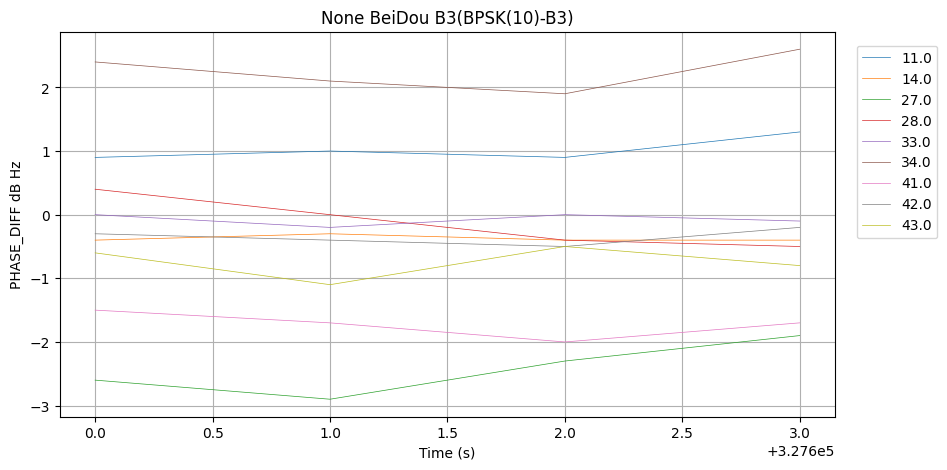

Plotting PHASE_DIFF vs adj_time for BeiDou, B1


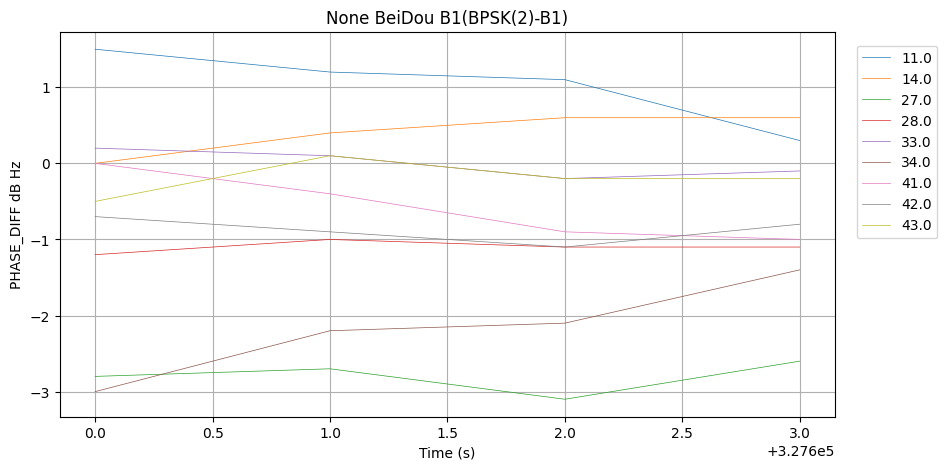

Plotting PHASE_DIFF vs adj_time for BeiDou, E5B/B2


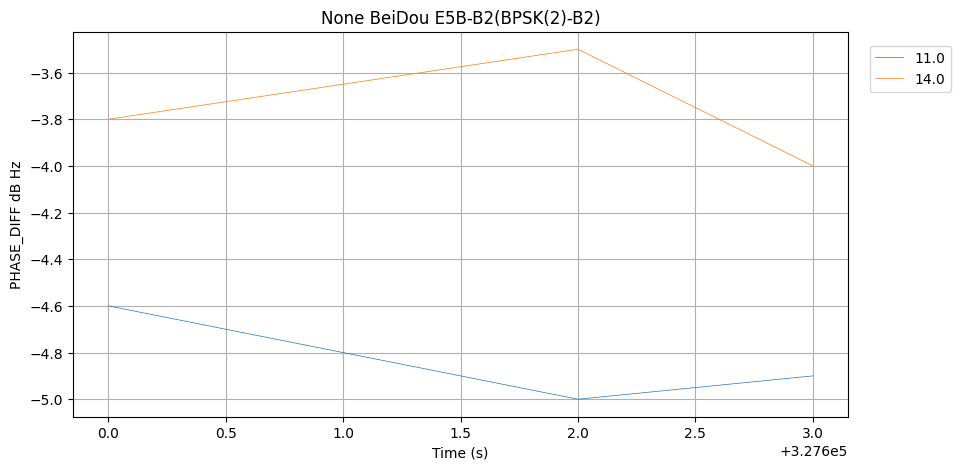

Plotting PHASE_DIFF vs adj_time for GLONASS, L1


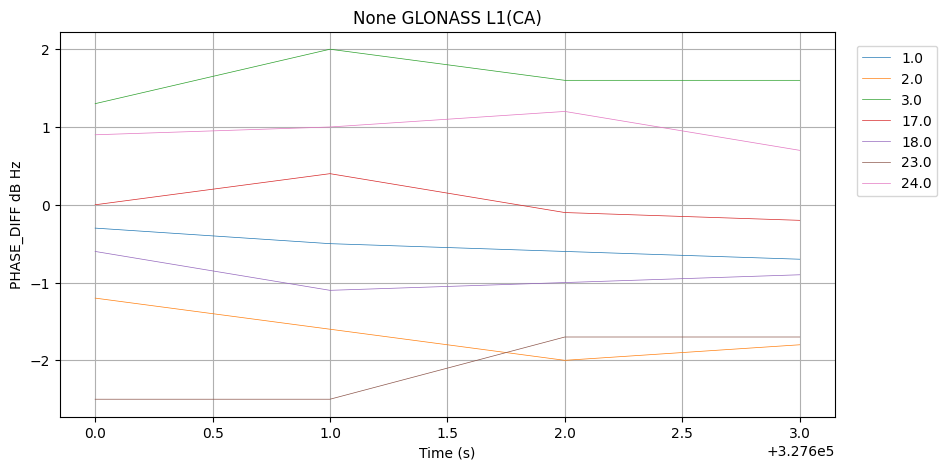

Plotting PHASE_DIFF vs adj_time for GLONASS, E5A+B
Plotting PHASE_DIFF vs adj_time for GLONASS, L2


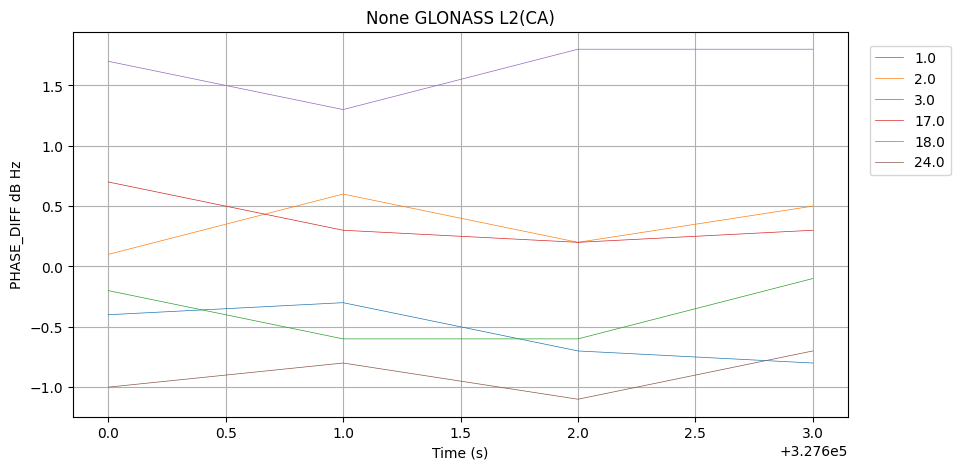

Plotting PHASE_DIFF vs adj_time for GLONASS, E6
Plotting PHASE_DIFF vs adj_time for GLONASS, L5/E5A
Plotting PHASE_DIFF vs adj_time for GLONASS, B3
Plotting PHASE_DIFF vs adj_time for GLONASS, B1
Plotting PHASE_DIFF vs adj_time for GLONASS, E5B/B2


In [40]:
FIGSIZE = (10, 5)
YLIM = [25, 60]

# obs_png_fname() is used in the obs_plot_*() functions, and in the
# gen_diff_html() function. Using a function for the fname provides a
# consistent way to generate the file names, so that the HTML report includes
# the right *.png files.
def obs_png_fname(fname_base, sv, freq, track, x, label=None):
    '''
    create a filename based on features used to create an observation png.
    '''
    s = '{}_d35_19-{}-{}({})-{}'.format(
            fname_base, sv, freq, D_TRACK_TYPE[track], x)
    if label:
        s = s + '_' + label
    s = s + '.png'
    return s


def obs_plot_cno(df, fname_base, col='CNo', ylim=YLIM, x='adj_time',
                 group_by_x=False):
    '''
    Plot a columnn of observation data, by Time (x-axis). One plot per SVType
    and Freq unique combination. Multiple SV numbers per plot.
    '''
    sv_types = df.SVType.unique()
    dft = df.set_index(x, inplace=False)
    for s in sv_types:
        freqs = df.Freq.unique()
        for f in freqs:
            print(f'Plotting {col} vs {x} for {s}, {f}')
            q = "SVType=='{}' and Freq=='{}'".format(s, f)
            dfqsf = dft.query(q)
            track_list = dfqsf.Track.unique()
            for tn in track_list:
                dfqsft = dfqsf.query('Track=={}'.format(tn))

                plt.figure(1, figsize=FIGSIZE)
                #plt.clf()
                if group_by_x:
                    dfplot = dfqsft.groupby([x, 'SV'])[col].median().unstack()
                    dfplot.plot(
                            linestyle='-', linewidth='0.5', figsize=FIGSIZE)
                    plt.ylabel(f'Median {col} dB Hz')
                else:
                    dfplot = dfqsft.groupby('SV')[col]
                    dfplot.plot(
                            linestyle='-', linewidth='0.5', figsize=FIGSIZE)
                    plt.ylabel(f'{col} dB Hz')
                #plt.ylim(ylim)
                if x == 'Time' or x == 'adj_time':
                    plt.xlabel('Time (s)')
                elif x == 'El':
                    plt.xlabel('Elevation (deg)')
                    plt.xlim([0, 90])
                else:
                    plt.xlabel(x)
                plt.legend(
                        bbox_to_anchor=(1.01, 1),
                        loc="upper left",
                        borderaxespad=1,
                        )
                plt.grid(True)
                fclean = f.replace('/', '-')
                plt.title("{} {} {}({})".format(
                    fname_base, s, fclean, D_TRACK_TYPE[tn]))
                #plt.savefig(obs_png_fname(fname_base, s, fclean, tn, x))
                #plt.close()
                plt.show()
obs_plot_cno(df_diff, None, col='PHASE_DIFF') #, ylim=YLIM, x='adj_time', group_by_x=False)

In [25]:
list(df_diff.columns) #.query("SVType=='Galileo' and Freq=='E5A+B'")

['Week',
 'Time',
 'SV',
 'SVType',
 'Freq',
 'PHASE',
 'PHASE',
 'Track',
 'SVChan',
 'FDMA',
 'Az',
 'El',
 'adj_time']